In [1]:
import fasttext
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datasets import load_from_disk, Dataset, DatasetDict

In [2]:
sns.set()
sns.set_style("whitegrid", {"axes.grid": False})

In [3]:
from sklearnex import patch_sklearn

patch_sklearn()

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [4]:
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [5]:
seed = 42
clean_data_path = "./data/irony_clean_data"

In [6]:
encoder = fasttext.load_model("./models/cc.ar.300.bin")

In [7]:
dataset = load_from_disk(clean_data_path)
dataset

Dataset({
    features: ['labels', 'text'],
    num_rows: 12037
})

In [8]:
def vectorize(batch):
    return {"features": [encoder.get_sentence_vector(t) for t in batch["text"]]}

In [9]:
encoded_data = dataset.map(vectorize, batched=True)
encoded_data

Parameter 'function'=<function vectorize at 0x000001A28A4383A0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/12037 [00:00<?, ? examples/s]

Dataset({
    features: ['labels', 'text', 'features'],
    num_rows: 12037
})

In [10]:
train_data, valid_data = train_test_split(
    encoded_data.to_pandas(),
    random_state=seed,
    train_size=0.6,
    stratify=dataset[:]["labels"],
)

valid_data, test_data = train_test_split(
    valid_data,
    random_state=seed,
    train_size=0.5,
    stratify=valid_data["labels"],
)

In [11]:
train_data = train_data.reset_index(drop=True)
valid_data = valid_data.reset_index(drop=True)
test_data = test_data.reset_index(drop=True)

In [12]:
encoded_data = DatasetDict({})
encoded_data["train"] = Dataset.from_pandas(
    pd.concat([train_data, valid_data], ignore_index=True)
)
encoded_data["test"] = Dataset.from_pandas(test_data)
encoded_data

DatasetDict({
    train: Dataset({
        features: ['labels', 'text', 'features'],
        num_rows: 9629
    })
    test: Dataset({
        features: ['labels', 'text', 'features'],
        num_rows: 2408
    })
})

In [13]:
label_names = ["Non-Sarcasm", "Sarcasm"]

In [14]:
label2id = {label_names[i]: i for i in range(len(label_names))}
id2label = {i: label_names[i] for i in range(len(label_names))}

In [15]:
w = encoded_data["train"].to_pandas().labels.value_counts(normalize=True).to_list()
w = {i: w[i] for i in range(len(w))}
w

{0: 0.8842039671824696, 1: 0.11579603281753038}

In [16]:
train_params = {"penalty": "l1", "solver": "liblinear", "C": 1000.0}

In [17]:
model = LogisticRegression(
    class_weight=w, random_state=seed, max_iter=int(1e5), verbose=1, **train_params
)
model.fit(X=encoded_data["train"][:]["features"], y=encoded_data["train"][:]["labels"])

[LibLinear]

LogisticRegression(C=1000.0,
                   class_weight={0: 0.8842039671824696, 1: 0.11579603281753038},
                   max_iter=100000, penalty='l1', random_state=42,
                   solver='liblinear', verbose=1)

In [18]:
preds_test = model.predict(encoded_data["test"][:]["features"])

In [19]:
print(
    classification_report(
        encoded_data["test"][:]["labels"], preds_test, target_names=label_names
    )
)

              precision    recall  f1-score   support

 Non-Sarcasm       0.90      1.00      0.94      2129
     Sarcasm       0.87      0.12      0.21       279

    accuracy                           0.90      2408
   macro avg       0.88      0.56      0.58      2408
weighted avg       0.89      0.90      0.86      2408



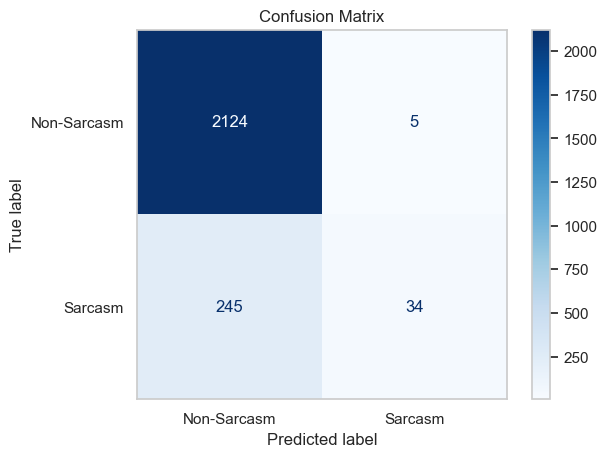

In [20]:
cm = confusion_matrix(encoded_data["test"][:]["labels"], preds_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.savefig("./data/cm_base.png", dpi=720)
plt.show()